In [1]:
! git clone https://github.com/jianxu305/nCov2019_analysis/
#! git pull

fatal: destination path 'nCov2019_analysis' already exists and is not an empty directory.


In [0]:
import sys
import os
os.chdir('/content/nCov2019_analysis/src')

sys.path.append('/content/nCov2019_analysis/src')

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import utils   # some convenient functions
import matplotlib.font_manager as mfm
import datetime

%load_ext autoreload
%autoreload 2

In [4]:
dxy_raw = utils.load_chinese_data()

Last update:  2020-03-06 09:20:02.598000
Data date range:  2020-01-24 to 2020-03-06
Number of rows in raw data:  64790


In [0]:
dxy_frm = utils.aggDaily(dxy_raw)

In [0]:
jhs_raw = utils.load_jhs_raw()

In [0]:
jhs_frm = utils.jhs_daily(jhs_raw)

In [8]:
jhs_frm.tail()

,province/state,country/region,Last Update,cum_confirmed,cum_dead,cum_cured,Latitude,Longitude,update_time,update_date,new_confirmed,new_dead,new_cured
2263,"Santa Rosa County, FL",US,2020-03-05T20:03:03,1.0,0.0,0.0,30.7690,-86.9824,2020-03-05 20:03:03,2020-03-05,1.0,0.0,0.0
2264,"Snohomish County, WA",US,2020-03-05T20:23:07,18.0,1.0,0.0,48.0330,-121.8339,2020-03-05 20:23:07,2020-03-05,10.0,0.0,0.0
2265,"Westchester County, NY",US,2020-03-05T21:33:03,18.0,0.0,0.0,41.1220,-73.7949,2020-03-05 21:33:03,2020-03-05,8.0,0.0,0.0
2266,"Williamson County, TN",US,2020-03-05T23:33:03,1.0,0.0,0.0,35.9179,-86.8622,2020-03-05 23:33:03,2020-03-05,1.0,0.0,0.0
2267,,United Arab Emirates,2020-03-05T23:53:02,29.0,0.0,5.0,24.0000,54.0000,2020-03-05 23:53:02,2020-03-05,2.0,0.0,0.0


## 1. Sanity Check
### 1.1 Take a Brief Look at the data

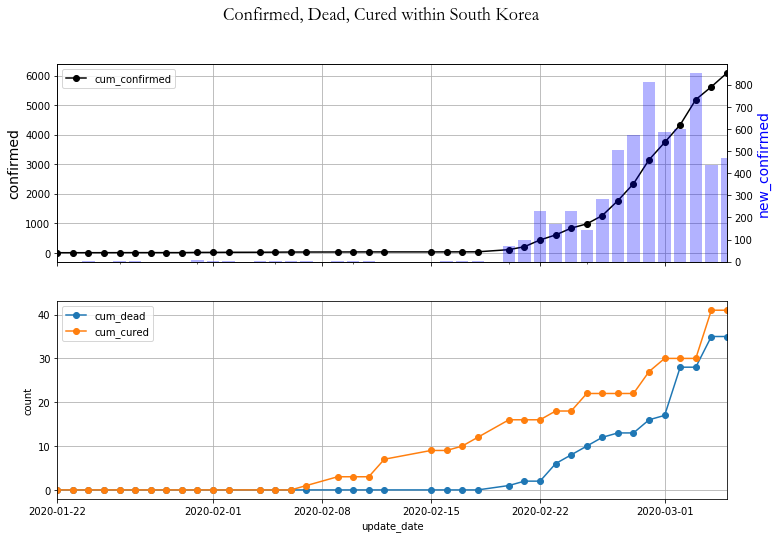

In [9]:
fig = utils.tsplot_conf_dead_cured(jhs_frm[jhs_frm['country/region'] == 'South Korea'], 
                                   title='Confirmed, Dead, Cured within South Korea', figsize=(12, 8))

### 1.2 Compare with Ding Xiang Yuan Chinese Data

In [0]:
jhs_china = jhs_frm[jhs_frm['country/region'] == 'Mainland China'].groupby(['update_date'])[['cum_confirmed', 'cum_dead']].agg('sum')
jhs_china = jhs_china.add_suffix('_JHS').reset_index()

In [0]:
dxy_china = dxy_frm.groupby(['update_date'])[['cum_confirmed', 'cum_dead']].agg('sum')
dxy_china = dxy_china.add_suffix('_DXY').reset_index()

In [0]:
comp = pd.merge(jhs_china, dxy_china, on='update_date').set_index('update_date')

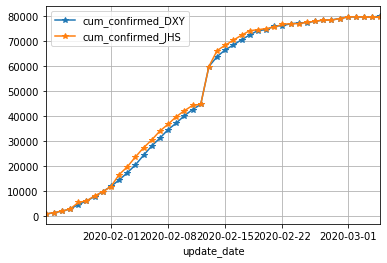

In [13]:
comp.plot(y=['cum_confirmed_DXY', 'cum_confirmed_JHS'], marker='*', grid=True)

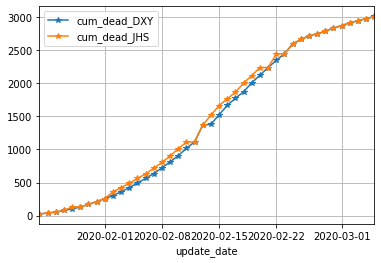

In [14]:
comp.plot(y=['cum_dead_DXY', 'cum_dead_JHS'], marker='*', grid=True)

## 2. Mortality Rate vs Confirmed Count

In [15]:
!pip install chart_studio

In [0]:
import plotly.express as px
import chart_studio
import chart_studio.plotly as py
import plotly.graph_objects as go
import plotly.io as pio

In [0]:
api_key  = ''  # use you own key
user_name = ''  # use your own user name
chart_studio.tools.set_credentials_file(username=user_name, api_key=api_key)

In [0]:
# most international data only has country info, so do not drill down to finer level now
country_frm = jhs_frm.groupby(['country/region', 'update_date']).agg('sum')  

### Remove Some Data Problem
Japan and US has some dates with negative new_confirm

In [19]:
country_frm[country_frm['new_confirmed'] < 0]

cum_confirmed  cum_dead  ...  new_dead  new_cured
country/region update_date                           ...                     
Japan          2020-01-23             1.0       0.0  ...       0.0        0.0
               2020-02-07            25.0       0.0  ...       0.0        0.0

[2 rows x 8 columns]

In [0]:
country_frm['new_confirmed'] = np.maximum(0, country_frm['new_confirmed'])   # Japan 1/23, 2/7, US 2/24 have new confirmed < 0, looks like data error

### Add Mortality Rate, Moving Average, etc

In [0]:
country_frm['mortality_rate'] = country_frm['cum_dead'] / country_frm['cum_confirmed']
country_frm = utils.add_moving_average(country_frm, ['country/region'], win_size=3)

In [0]:
# The following columns are mainly for plot rendering
country_frm['new_confirmed_logMA'] = np.log10(country_frm['new_confirmed_MA'] + 2)
color_countries = ['Mainland China', 'Japan', 'South Korea', 'Iran', 'Italy', 'Germany', 
                   'US', 'France', 'Spain', 'Diamond Princess', 'Thailandl', 'Taiwan', 'Hong Kong',
                   'Singapore', 'UK', 'Iraq']
country_frm['color'] = np.where(country_frm.index.get_level_values('country/region').isin(color_countries), 
                                country_frm.index.get_level_values('country/region'), 
                                'Other')
country_ex_china = country_frm[country_frm.index.get_level_values('country/region') != 'Mainland China']

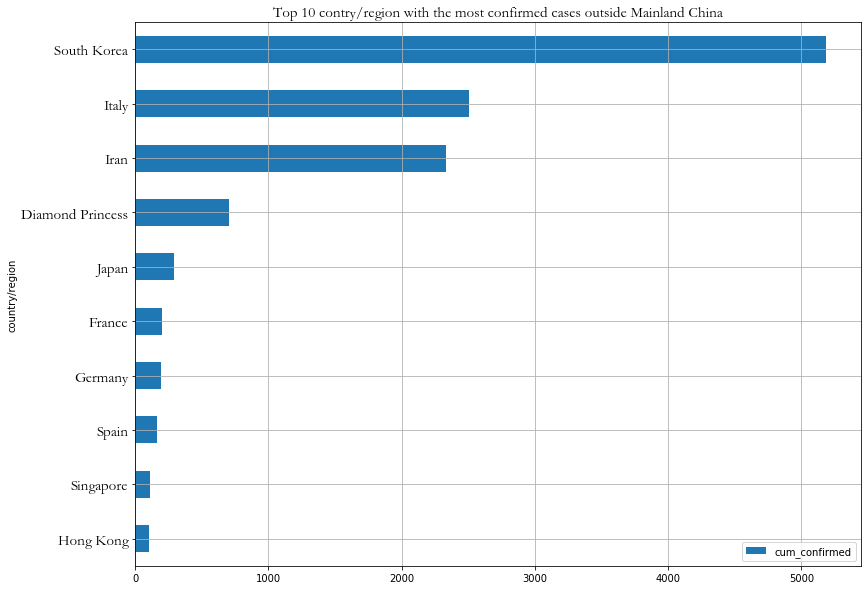

In [18]:
fig = utils.cross_sectional_bar(country_ex_china.reset_index(), '2020-03-03', 'cum_confirmed', 'country/region', 10,
                                title='Top 10 contry/region with the most confirmed cases outside Mainland China')

#### Flashback to 2020-02-26

In [42]:
date = datetime.date(2020, 2, 26)
frm = country_ex_china.loc[(slice(None), date), :].reset_index()
#frm = frm[frm['cum_confirmed'] >= 5]  # only show countries with more than 5 confirmed cases
frm = frm[frm['color'] != 'Other']
fig = px.scatter(frm,
                 x='cum_confirmed', 
                 y='mortality_rate',  
                 size='new_confirmed_logMA', 
                 size_max=frm['new_confirmed_logMA'].max() * 8,
                 color='color',
                 text='country/region',
                 #color_continuous_scale=px.colors.sequential.Jet,
                 hover_data=['country/region', 'cum_dead', 'cum_confirmed', 'new_confirmed', 'new_dead'],
                 title='Mortality Rate vs Confirmed by Country/Region as of ' + str(date))
fig.update_layout(xaxis_type="log", xaxis_title='Confirmed Count', yaxis_title='Mortality Rate')
fig.layout.yaxis.tickformat = ',.1%'  # set display to % format
# add lines to split the region
fig.add_trace(go.Scatter(x=[100, 100], y=[-0.01, 0.15], mode="lines", line={'dash': 'dot', 'color': 'orange'}))
fig.add_trace(go.Scatter(x=[500, 500], y=[-0.01, 0.15], mode="lines", line={'dash': 'dot', 'color': 'orange'}))
fig.add_trace(go.Scatter(x=[4, 2000], y=[0.02, 0.02], mode="lines", line={'dash': 'dot', 'color': 'orange'}))
fig.add_trace(go.Scatter(x=[4, 2000], y=[0.01, 0.01], mode="lines", line={'dash': 'dot', 'color': 'orange'}))
fig.update_traces(textposition='top center')

fig.show()

In [0]:
pio.write_html(fig, file='index.html', auto_open=True)

### 2020-03-02

In [43]:
date = datetime.date(2020, 3, 2)
frm = country_ex_china.loc[(slice(None), date), :].reset_index()
#frm = frm[frm['cum_confirmed'] >= 5]  # only show countries with more than 5 confirmed cases
frm = frm[frm['color'] != 'Other']
fig = px.scatter(frm,
                 x='cum_confirmed', 
                 y='mortality_rate',  
                 size='new_confirmed_logMA', 
                 size_max=frm['new_confirmed_logMA'].max() * 8,
                 color='color',
                 text='country/region',
                 #color_continuous_scale=px.colors.sequential.Jet,
                 hover_data=['country/region', 'cum_dead', 'cum_confirmed', 'new_confirmed', 'new_dead'],
                 title='Mortality Rate vs Confirmed by Country/Region as of ' + str(date))
fig.update_layout(xaxis_type="log", xaxis_title='Confirmed Count', yaxis_title='Mortality Rate')
fig.layout.yaxis.tickformat = ',.1%'  # set display to % format
fig.update_traces(textposition='top center')
# add lines to split the region
fig.add_trace(go.Scatter(x=[100, 100], y=[-0.01, 0.08], mode="lines", line={'dash': 'dot', 'color': 'orange'}))
fig.add_trace(go.Scatter(x=[500, 500], y=[-0.01, 0.08], mode="lines", line={'dash': 'dot', 'color': 'orange'}))
fig.add_trace(go.Scatter(x=[20, 5000], y=[0.02, 0.02], mode="lines", line={'dash': 'dot', 'color': 'orange'}))
fig.add_trace(go.Scatter(x=[20, 5000], y=[0.01, 0.01], mode="lines", line={'dash': 'dot', 'color': 'orange'}))
fig.show()

### Comparison: China has been stable in the past two weeks

In [0]:
china_frm = dxy_frm.copy()
china_frm['province_name'] = np.where(china_frm['city_name'] == '武汉', '武汉', china_frm['province_name'])  # treat Wuhan as a province
china_frm['province_name'] = np.where(china_frm['province_name'] == '湖北省', '湖北省除武汉', china_frm['province_name'])
china_province = china_frm.groupby(['province_name', 'update_date']).agg('sum')

In [53]:
china_province = utils.add_moving_average(china_province, ['province_name'], 3)
china_province['mortality_rate'] = china_province['cum_dead'] / china_province['cum_confirmed']
china_province['new_confirmed_logMA'] = np.log10(china_province['new_confirmed_MA'] + 2)

/usr/local/lib/python3.6/dist-packages/pandas/core/series.py:856: RuntimeWarning:

divide by zero encountered in log10

/usr/local/lib/python3.6/dist-packages/pandas/core/series.py:856: RuntimeWarning:

invalid value encountered in log10



In [61]:
date = datetime.date(2020, 2, 19)
frm = china_province.loc[(slice(None), date), :].reset_index()
#frm = frm[frm['cum_confirmed'] >= 5]  # only show countries with more than 5 confirmed cases
#frm = frm[frm['color'] != 'Other']
fig = px.scatter(frm,
                 x='cum_confirmed', 
                 y='mortality_rate',  
                 size='new_confirmed_logMA', 
                 size_max=frm['new_confirmed_logMA'].max() * 8,
                 #color='color',
                 text='province_name',
                 #color_continuous_scale=px.colors.sequential.Jet,
                 hover_data=['province_name', 'cum_dead', 'cum_confirmed', 'new_confirmed', 'new_dead'],
                 title='Mortality Rate vs Confirmed by Country/Region as of ' + str(date))
fig.update_layout(xaxis_type="log", xaxis_title='Confirmed Count', yaxis_title='Mortality Rate')
fig.layout.yaxis.tickformat = ',.1%'  # set display to % format
# add lines to split the region
fig.add_trace(go.Scatter(x=[100, 100], y=[-0.005, 0.05], mode="lines", line={'dash': 'dot', 'color': 'orange'}))
fig.add_trace(go.Scatter(x=[500, 500], y=[-0.005, 0.05], mode="lines", line={'dash': 'dot', 'color': 'orange'}))
fig.add_trace(go.Scatter(x=[15, 50000], y=[0.02, 0.02], mode="lines", line={'dash': 'dot', 'color': 'orange'}))
fig.add_trace(go.Scatter(x=[15, 50000], y=[0.01, 0.01], mode="lines", line={'dash': 'dot', 'color': 'orange'}))
fig.update_traces(textposition='top center')

fig.show()

### China on 2020-03-02, bubbles are diminishing, so spread is slowed down

In [58]:
date = datetime.date(2020, 3, 2)
frm = china_province.loc[(slice(None), date), :].reset_index()
#frm = frm[frm['cum_confirmed'] >= 5]  # only show countries with more than 5 confirmed cases
#frm = frm[frm['color'] != 'Other']
fig = px.scatter(frm,
                 x='cum_confirmed', 
                 y='mortality_rate',  
                 size='new_confirmed_logMA', 
                 size_max=frm['new_confirmed_logMA'].max() * 8,
                 #color='color',
                 text='province_name',
                 #color_continuous_scale=px.colors.sequential.Jet,
                 hover_data=['province_name', 'cum_dead', 'cum_confirmed', 'new_confirmed', 'new_dead'],
                 title='Mortality Rate vs Confirmed by Country/Region as of ' + str(date))
fig.update_layout(xaxis_type="log", xaxis_title='Confirmed Count', yaxis_title='Mortality Rate')
fig.layout.yaxis.tickformat = ',.1%'  # set display to % format
# add lines to split the region
fig.add_trace(go.Scatter(x=[100, 100], y=[-0.005, 0.05], mode="lines", line={'dash': 'dot', 'color': 'orange'}))
fig.add_trace(go.Scatter(x=[500, 500], y=[-0.005, 0.05], mode="lines", line={'dash': 'dot', 'color': 'orange'}))
fig.add_trace(go.Scatter(x=[50, 50000], y=[0.02, 0.02], mode="lines", line={'dash': 'dot', 'color': 'orange'}))
fig.add_trace(go.Scatter(x=[50, 50000], y=[0.01, 0.01], mode="lines", line={'dash': 'dot', 'color': 'orange'}))
fig.update_traces(textposition='top center')

fig.show()